# Neural Network with reduced dimension (PCA)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

result_path = "../results/"

2022-12-21 11:42:51.978802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load and prepare data:

In [2]:
path = "../data/"
file_pre = "prep_data.csv"
file_data = "CTG.xls"

fetus_pre = pd.read_csv(path+file_pre)
fetus_pre = fetus_pre.reindex(np.random.permutation(fetus_pre.index))
fetus = pd.read_excel(path+file_data, sheet_name = "Data",header=1)
fetus = fetus.reindex(np.random.permutation(fetus.index))
# Columns to be considered in the dataset
columns = ["LB", "AC", "FM", "UC", "DL", "DP", 
           "ASTV", "MSTV", "ALTV", "MLTV", "Width", "Min", 
           "Max", "Nmax", "Nzeros", "Mode", "Mean", "Median", "Variance", "Tendency"]
# Prepocessed dataset
X = fetus_pre[columns]
y = fetus_pre["NSP"]

# Raw dataset
X_raw = fetus[columns]
y_raw = fetus["NSP"]

# One-hot enconding of target values
y_cat = utils.to_categorical(y-1)
y_cat_raw = utils.to_categorical(y_raw-1)

# Split train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, random_state = 45, train_size = 0.8)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_cat_raw, random_state = 45, train_size = 0.8)


Define an useful function to evaluate the model:

In [3]:
def evaluate(y_pred, y_test, model):
    
    # Apply argmax
    y_pred = np.argmax(y_pred,axis=1)
    y_compare = np.argmax(y_test,axis=1)
    
    print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
    print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))
    
    # Print the confunsion matrix
    cm = confusion_matrix(y_compare, y_pred, normalize="all")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
    disp.plot()    
    
    
    # Plot the loss function
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.plot(np.sqrt(model.history['loss']), 'r', label='train')
    ax.plot(np.sqrt(model.history['val_loss']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=10)
    ax.set_ylabel(r'Loss', fontsize=10)
    ax.legend()
    ax.tick_params(labelsize=10)
    
    # Plot the accuracy
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.plot(np.sqrt(model.history['accuracy']), 'r', label='train')
    ax.plot(np.sqrt(model.history['val_accuracy']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=10)
    ax.set_ylabel(r'Accuracy', fontsize=10)
    ax.legend()
    ax.tick_params(labelsize=10)



# PCA

Principal Component Analysis is a technique used to reduce the size of a problem. In this analysis, the application of this technique can lead to a considerable reduction in the size of the input and thus of the parameters to be calculated in the neural network. 

In order to determine an acceptable threshold to which to reduce the dimensionality of the problem, an analysis on the cumulative expected variance is carried out.

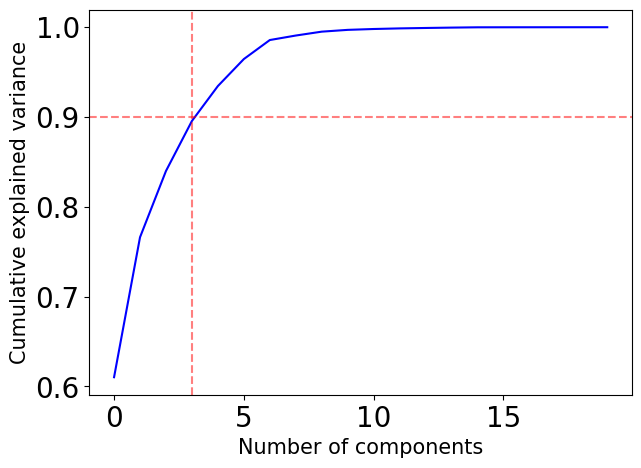

In [4]:
import matplotlib.pyplot as plt

#Apply PCA to raw data
pca = PCA()
pca.fit(X)

fig, ax = plt.subplots(figsize=(7,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_),c="b")
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');
ax.axhline(0.90, c = "red", linestyle="--", alpha = 0.5)
ax.axvline(3, c = "red", linestyle="--", alpha = 0.5)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

# plt.savefig(result_path+"/CEV") 

Applying PCA to both raw and scaled data, the cumulative explained variance displays different trends. A 90% variance is obtained with 3 components for the raw data and for 10 components for the scaled data. 

The 3 projected components are shown in figure below. It is possible to spot some kind of clustering, detecting regions in which each class is predominant to the other. This is a good reasoning behind the application of PCA.

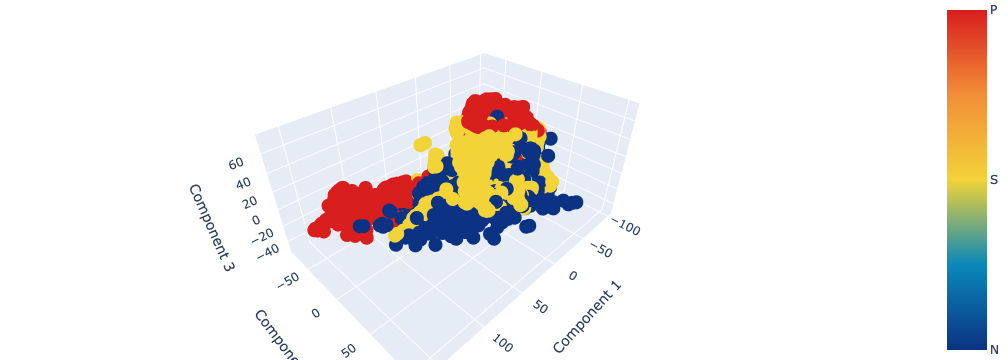

In [5]:
pca = PCA(3) 
X3 = pca.fit_transform(X)

# Split in train and test dataset
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y_cat, random_state = 45, train_size = 0.8)

# Draw results for PCA
# Source: https://plotly.com/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d( x=X3[:,0], y=X3[:,1], z=X3[:,2], 
                                   mode='markers', 
                                   marker=dict( color = y, 
                                                colorscale = 'portland', 
                                                colorbar=dict( thickness = 40, 
                                                               tickvals=[1, 2, 3],
                                                               ticktext=['N', 'S', 'P'])))])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), scene = dict(xaxis_title="Component 1",yaxis_title="Component 2",zaxis_title="Component 3"))


fig.show()

# Change activation function

In this part, we evaluate the sigmoid and ReLu functions to see how they affect the model's performance

## HL(15 nodes, sigmoid)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                60        
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


2022-12-21 11:43:01.091937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


31/31 [==============================] - 0s 866us/step
Accuracy: 0.84
Recall: 0.85


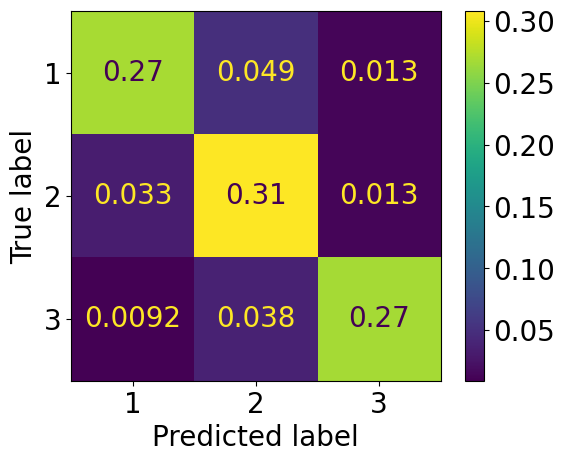

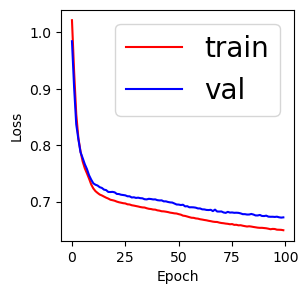

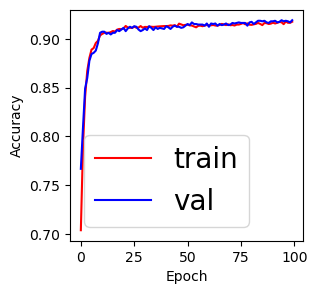

In [6]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100, validation_data=(X3_test, y3_test))
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

evaluate(y3_pred, y3_test,model_trace)

## HL(15 nodes, ReLu)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                60        
                                                                 
 dense_3 (Dense)             (None, 3)                 48        
                                                                 
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 794us/step
===RESULTS================================
Fit time: 15.292 s
Prediction time: 0.100 s
Accuracy: 0.83
Recall: 0.84


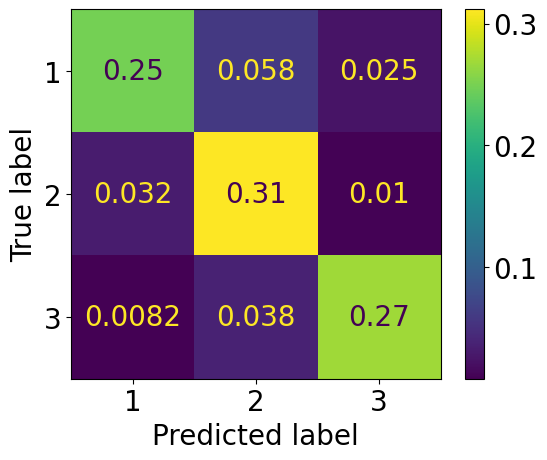

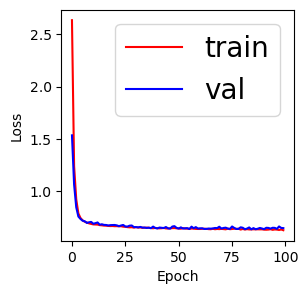

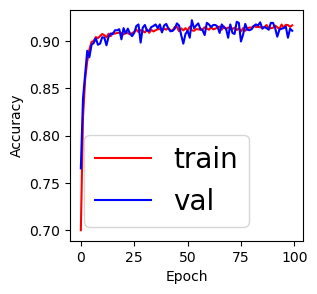

In [7]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100, validation_data=(X3_test, y3_test))
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
print("Prediction time: %.3f s"%pred_time)
evaluate(y3_pred, y3_test, model_trace)

# Change nodes in the hidden layer

In this section, we focus on trying to understand the pros and cons on using PCA in this particular case.

## HL(30 nodes, sigmoid)

Parameters difference:

- 3 feat: 213 params
- 20 feat: 723 params

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                120       
                                                                 
 dense_5 (Dense)             (None, 3)                 93        
                                                                 
Total params: 213
Trainable params: 213
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 843us/step
Accuracy: 0.87
Recall: 0.88


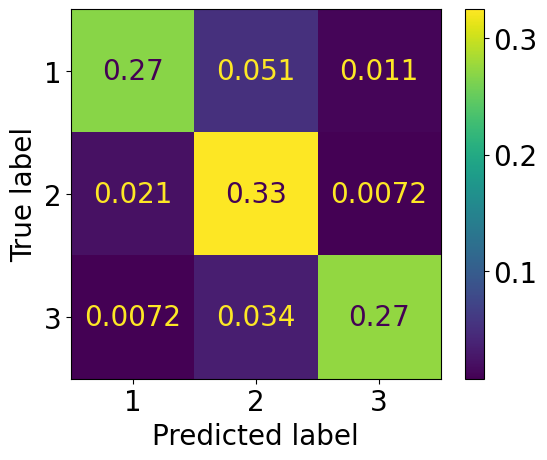

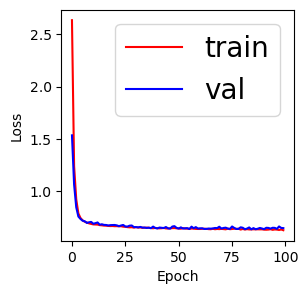

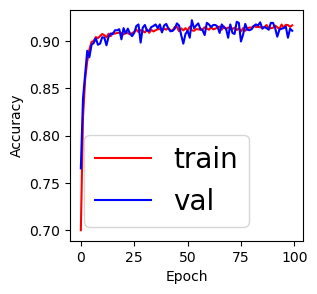

In [8]:
model = Sequential()
model.add(Dense(30, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X3_train,y3_train,verbose=0,epochs=200, validation_data=(X3_test, y3_test))

y3_pred = model.predict(X3_test)

evaluate(y3_pred, y3_test, model_trace)

## HL(60 nodes, sigmoid)

Parameters difference:

- 3 feat: 423 params
- 20 feat: 1443 params

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 60)                240       
                                                                 
 dense_7 (Dense)             (None, 3)                 183       
                                                                 
Total params: 423
Trainable params: 423
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 896us/step
Accuracy: 0.87
Recall: 0.88


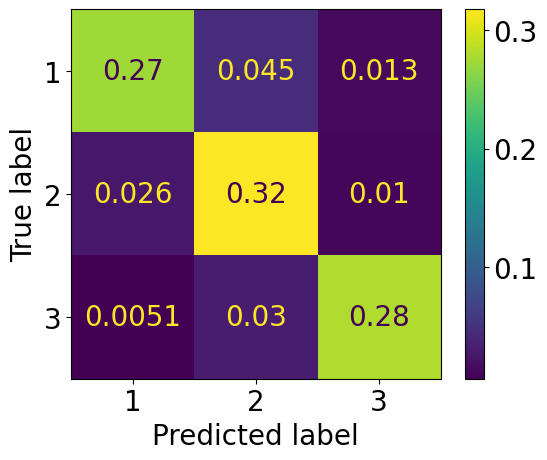

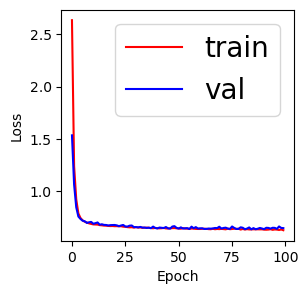

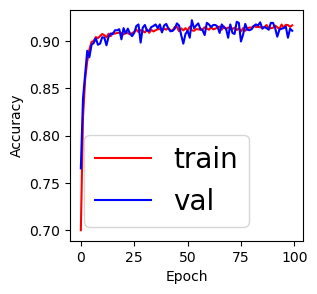

In [9]:
model = Sequential()
model.add(Dense(60, input_dim=X3.shape[1], activation='sigmoid'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

model.fit(X3_train,y3_train,verbose=0,epochs=100, validation_data=(X3_test, y3_test))

y3_pred = model.predict(X3_test)

evaluate(y3_pred, y3_test, model_trace)

# Increase layers

Our analysis continued trying different neural networks adding layers:

## HL(15 nodes, relu) x 2

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 15)                60        
                                                                 
 dense_9 (Dense)             (None, 15)                240       
                                                                 
 dense_10 (Dense)            (None, 3)                 48        
                                                                 
Total params: 348
Trainable params: 348
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 850us/step
===RESULTS================================
Fit time: 16.656 s
Prediction time: 0.108 s
Accuracy: 0.86
Recall: 0.87


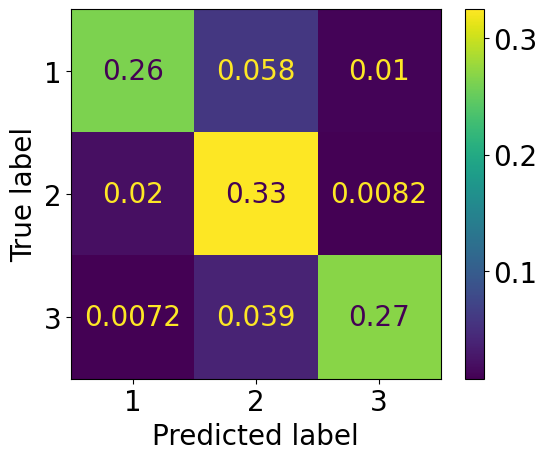

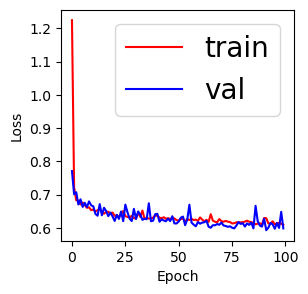

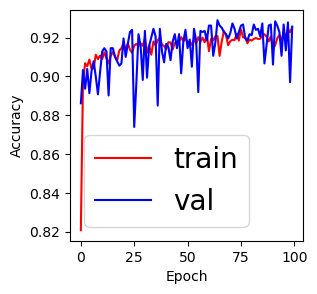

In [10]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100, validation_data=(X3_test, y3_test))
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
print("Prediction time: %.3f s"%pred_time)
evaluate(y3_pred,y_test,model_trace)

## HL(15 nodes, relu) x 4

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 15)                60        
                                                                 
 dense_12 (Dense)            (None, 15)                240       
                                                                 
 dense_13 (Dense)            (None, 15)                240       
                                                                 
 dense_14 (Dense)            (None, 15)                240       
                                                                 
 dense_15 (Dense)            (None, 3)                 48        
                                                                 
Total params: 828
Trainable params: 828
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 963us/step
=

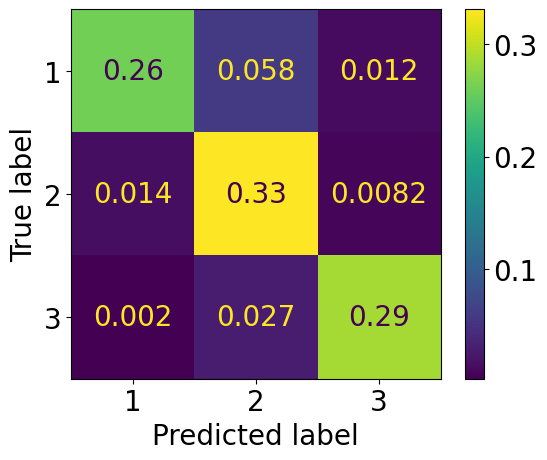

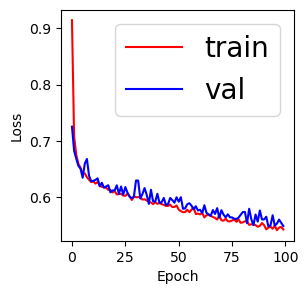

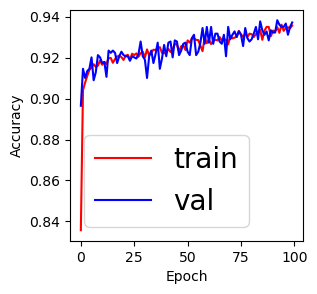

In [11]:
model = Sequential()
model.add(Dense(15, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100, validation_data=(X3_test, y3_test))
fit_time = time.time() - itime

itime = time.time()
y3_pred = model.predict(X3_test)
pred_time = time.time() - itime

print("===RESULTS================================")
print("Fit time: %.3f"%fit_time)
print("Prediction time: %.3f"%pred_time)
evaluate(y3_pred,y_test,model_trace)

## HL(30 nodes, relu), HL(15 nodes, relu)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 30)                120       
                                                                 
 dense_17 (Dense)            (None, 15)                465       
                                                                 
 dense_18 (Dense)            (None, 3)                 48        
                                                                 
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 927us/step
===RESULTS================================
Fit time: 16.779 s
Accuracy: 0.85
Recall: 0.86


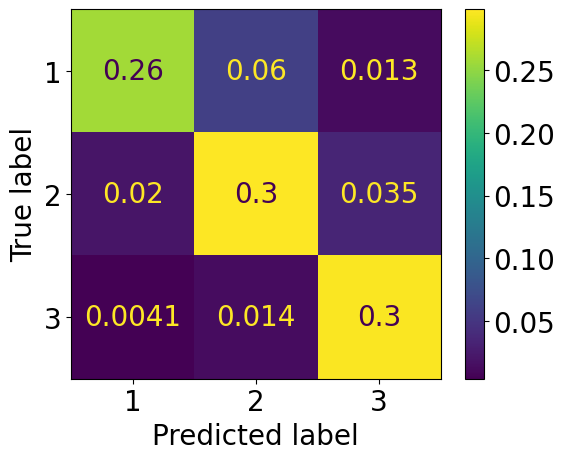

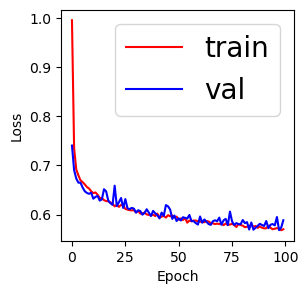

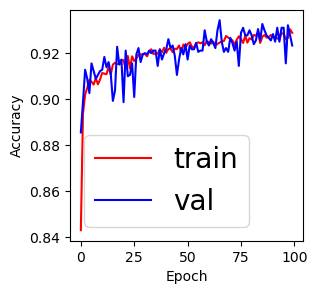

In [12]:
model = Sequential()
model.add(Dense(30, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100, validation_data=(X3_test, y3_test))
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
evaluate(y3_pred,y_test,model_trace)

## HL(60 nodes, relu), HL(50 nodes, relu), HL(40 nodes, relu), HL(30 nodes, relu)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 60)                240       
                                                                 
 dense_20 (Dense)            (None, 50)                3050      
                                                                 
 dense_21 (Dense)            (None, 40)                2040      
                                                                 
 dense_22 (Dense)            (None, 30)                1230      
                                                                 
 dense_23 (Dense)            (None, 3)                 93        
                                                                 
Total params: 6,653
Trainable params: 6,653
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 920us/st

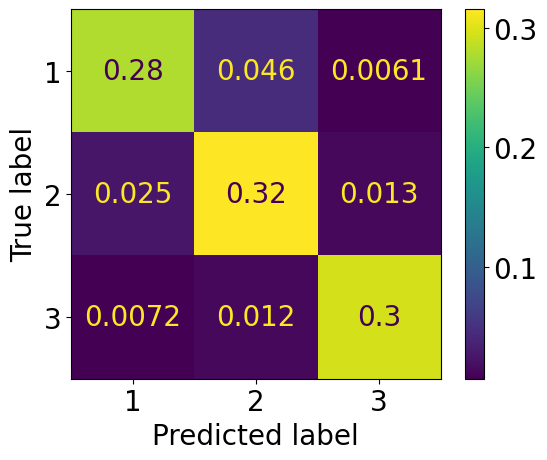

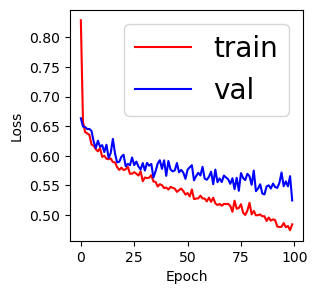

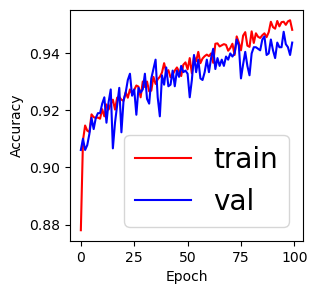

In [13]:
model = Sequential()
model.add(Dense(60, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=100, validation_data=(X3_test, y3_test))
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f"%fit_time)
print("Prediction time: %.3f"%pred_time)
evaluate(y3_pred,y_test,model_trace)

## HL(100 nodes, relu) x 4 - BEST ONE

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               400       
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dense_27 (Dense)            (None, 100)               10100     
                                                                 
 dense_28 (Dense)            (None, 3)                 303       
                                                                 
Total params: 31,003
Trainable params: 31,003
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/st

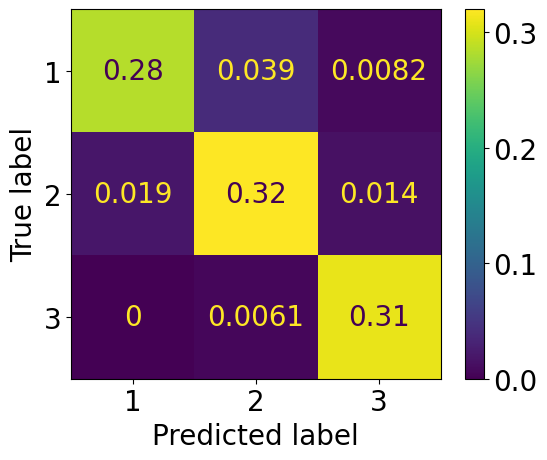

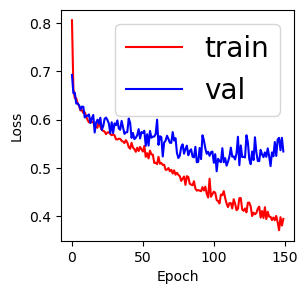

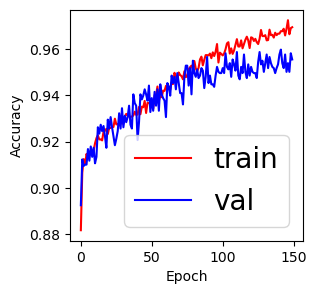

In [14]:
model = Sequential()
model.add(Dense(100, input_dim=X3.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

itime = time.time()
model_trace = model.fit(X3_train,y3_train,verbose=0,epochs=150, validation_data=(X3_test, y3_test))
fit_time = time.time() - itime

y3_pred = model.predict(X3_test)

print("===RESULTS================================")
print("Fit time: %.3f s"%fit_time)
evaluate(y3_pred,y_test,model_trace)

The latter network is the one that was selected for further analysis as it has excellent accuracy and recall values. It should be noted that the loss values for the validation set have a bizarre behaviour that could cause problems in the final test phase.